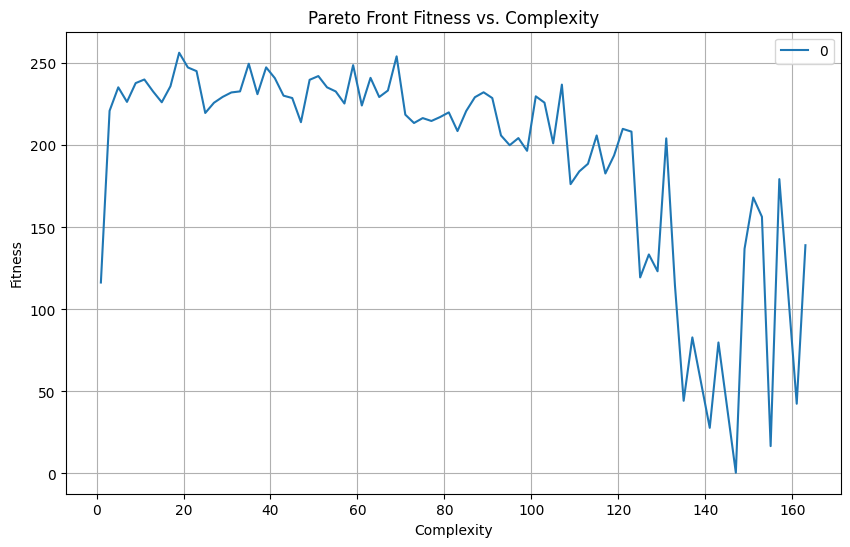

In [59]:
import pickle
import matplotlib.pyplot as plt
import numpy as np

exp1 = ["test_ant", "0"]
# exp2 = ["20250409_120719", "0.06"]
# exp3 = ["20250409_120749", "0.1"]
# exp4 = ["20250409_120758", "0.2"]

pareto_front = []

def get_valid_data(file_name):

    global pareto_front
    with open(file_name + ".pkl", "rb") as f:
        pareto_front = pickle.load(f)

    fitness = pareto_front.fitness.cpu()
    complexity = np.arange(len(fitness))

    valid_complexity = []
    valid_fitness = []
    for c, f in zip(complexity, fitness):
        if f > 0 and c > 0 and c < 256:
            valid_complexity.append(c)
            valid_fitness.append(f)

    return valid_complexity, valid_fitness


x_1, y_1 = get_valid_data("data/results/" + exp1[0])
# x_2, y_2 = get_valid_data("data/results/" + exp2[0])
# x_3, y_3 = get_valid_data("data/results/" + exp3[0])
# x_4, y_4 = get_valid_data("data/results/" + exp4[0])

# 绘制图表
plt.figure(figsize=(10, 6))
plt.plot(x_1, y_1, label=exp1[1])
# plt.plot(x_2, y_2, label=exp2[1])
# plt.plot(x_3, y_3, label=exp3[1])
# plt.plot(x_4, y_4, label=exp4[1])
plt.xlabel("Complexity")
plt.ylabel("Fitness")
plt.title("Pareto Front Fitness vs. Complexity")
plt.grid(True)
plt.legend()
plt.show()

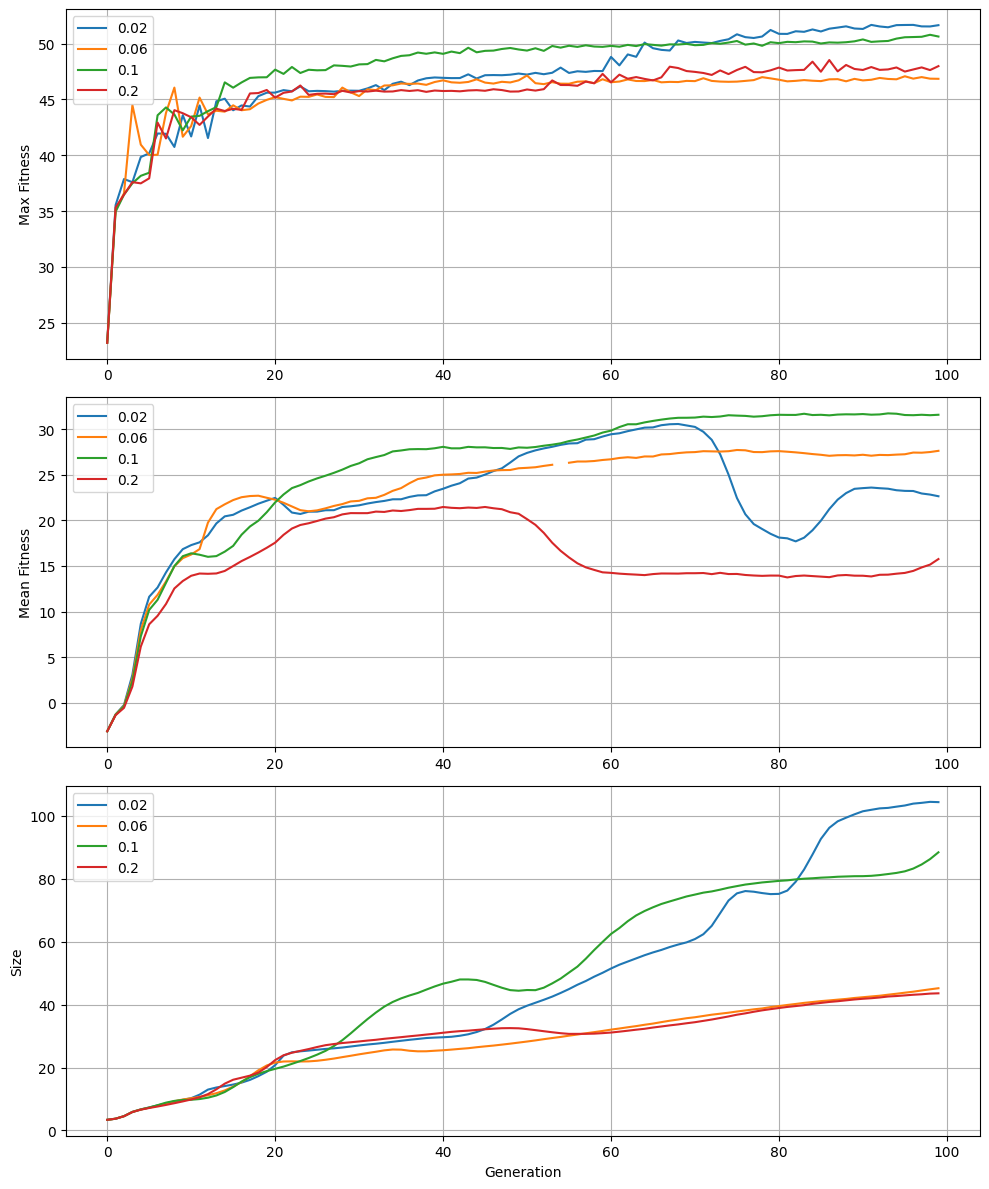

In [41]:
import matplotlib.pyplot as plt
import pandas as pd


def read_columns_with_pandas(file_name):
    df = pd.read_csv(file_name + ".csv")
    return {col: df[col].tolist() for col in df.columns}


data1 = read_columns_with_pandas("data/results/" + exp1[0])
data2 = read_columns_with_pandas("data/results/" + exp2[0])
data3 = read_columns_with_pandas("data/results/" + exp3[0])
data4 = read_columns_with_pandas("data/results/" + exp4[0])
gen = 100

plt.figure(figsize=(10, 12))

plt.subplot(3, 1, 1)
plt.plot(data1["generation"][:gen], data1["best_fitness"][:gen], label=exp1[1])
plt.plot(data2["generation"][:gen], data2["best_fitness"][:gen], label=exp2[1])
plt.plot(data3["generation"][:gen], data3["best_fitness"][:gen], label=exp3[1])
plt.plot(data4["generation"][:gen], data4["best_fitness"][:gen], label=exp4[1])
plt.ylabel("Max Fitness")
plt.grid(True)
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(data1["generation"][:gen], data1["mean_fitness"][:gen], label=exp1[1])
plt.plot(data2["generation"][:gen], data2["mean_fitness"][:gen], label=exp2[1])
plt.plot(data3["generation"][:gen], data3["mean_fitness"][:gen], label=exp3[1])
plt.plot(data4["generation"][:gen], data4["mean_fitness"][:gen], label=exp4[1])
plt.ylabel("Mean Fitness")
plt.grid(True)
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(data1["generation"][:gen], data1["mean_tree_size"][:gen], label=exp1[1])
plt.plot(data2["generation"][:gen], data2["mean_tree_size"][:gen], label=exp2[1])
plt.plot(data3["generation"][:gen], data3["mean_tree_size"][:gen], label=exp3[1])
plt.plot(data4["generation"][:gen], data4["mean_tree_size"][:gen], label=exp4[1])
plt.xlabel("Generation")
plt.ylabel("Size")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
import brax.envs
from brax.io import html, image
import torch, jax
import time

best_ind = torch.argmax(pareto_front.fitness)
best_solution = pareto_front.solution[best_ind]


def policy_fn(obs):
    torch_output = best_solution.forward(torch.utils.dlpack.from_dlpack(obs))
    torch_action = torch.tanh(torch_output)
    return jax.dlpack.from_dlpack(torch_action.detach())

# env = brax.envs.create(env_name="ant")
env = brax.envs.create(env_name="ant", backend ="spring")

# def make_jit_step(env):
#     @jax.jit
#     def step_fn(state, action):
#         return env.step(state, action)
#     return step_fn

# jit_step = make_jit_step(env)
jit_step = jax.jit(env.step)
# state = env.reset(jax.random.PRNGKey(0))
# action = policy_fn(state.obs)
# compiled_step = jit_step.lower(state, action).compile()

In [ ]:
def evaluate(policy_fn, env, num_steps=500):
    state = env.reset(jax.random.PRNGKey(8))
    # print(state.reward)
    trajectory = []
    for i in range(num_steps):

        tic = time.time()
        action = policy_fn(state.obs)
        toc = time.time() - tic
        # print(f"cal time: {toc}")

        tic = time.time()
        state = jit_step(state, action)
        toc = time.time() - tic
        print(f"env time: {toc}")

        print(i, state.done, state.reward, state.metrics)
        trajectory.append(state.pipeline_state)
    return trajectory

trajectory = evaluate(policy_fn, env)
# html_anim = html.render(env.sys, trajectory)
# image_anim = image.render_array(env.sys, trajectory, camera="track")

env time: 0.0009989738464355469
0 0.0 0.66716254 {'distance_from_origin': Array(0.6019828, dtype=float32), 'forward_reward': Array(-0.06601289, dtype=float32), 'reward_contact': Array(-0., dtype=float32, weak_type=True), 'reward_ctrl': Array(-0.2668246, dtype=float32), 'reward_forward': Array(-0.06601289, dtype=float32), 'reward_survive': Array(1., dtype=float32, weak_type=True), 'x_position': Array(0.09345803, dtype=float32), 'x_velocity': Array(-0.06601289, dtype=float32), 'y_position': Array(0.02796893, dtype=float32), 'y_velocity': Array(0.14848766, dtype=float32)}
env time: 0.0010051727294921875
1 0.0 0.96965104 {'distance_from_origin': Array(0.63151264, dtype=float32), 'forward_reward': Array(0.23651958, dtype=float32), 'reward_contact': Array(-0., dtype=float32, weak_type=True), 'reward_ctrl': Array(-0.26686853, dtype=float32), 'reward_forward': Array(0.23651958, dtype=float32), 'reward_survive': Array(1., dtype=float32, weak_type=True), 'x_position': Array(0.10528401, dtype=flo

In [62]:
import imageio

imageio.mimsave('/home/kelvin/test/evogp2/evogp2/experiment/data/results/test_ant_500.gif', image_anim, fps=30, loop = 1)

with open("trajectory.html", "w") as f:
    f.write(html_anim)

In [52]:
type(trajectory[0])

brax.generalized.base.State

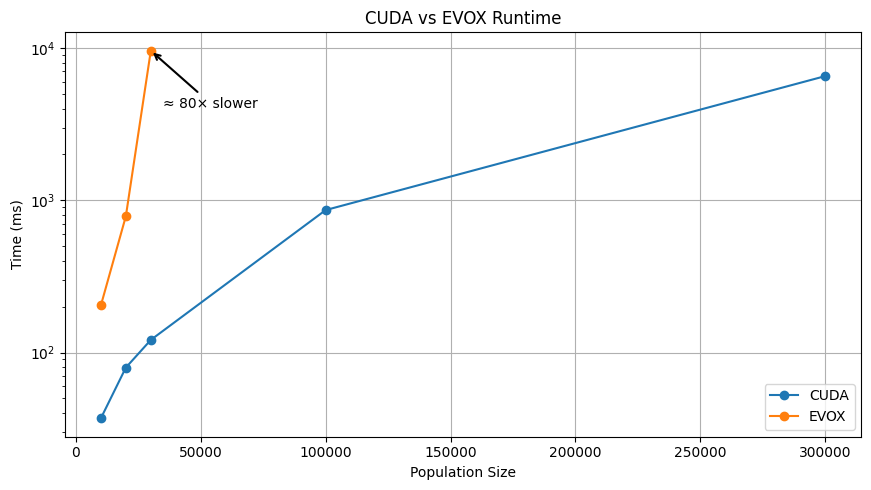

In [7]:
import matplotlib.pyplot as plt

# 使用真实数值的种群规模
pop_sizes = [10000, 20000, 30000, 100000, 300000]

# 数据
cuda_times = [36.9567, 79.5761, 120.968, 861.506, 6529.47]
evox_times = [203.53274345397948, 784.1367959976197, 9584.518790245056, None, None]

# 画图
plt.figure(figsize=(9, 5))
plt.plot(pop_sizes, cuda_times, marker='o', label='CUDA')
plt.plot(pop_sizes, evox_times, marker='o', label='EVOX')
plt.xlabel("Population Size")
plt.ylabel("Time (ms)")
plt.title("CUDA vs EVOX Runtime")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.yscale('log')

# 添加箭头标注说明 30k 情况下的差距
x_annotate = 30000
cuda_y = cuda_times[2]
evox_y = evox_times[2]

plt.annotate(
    "≈ 80× slower",
    xy=(x_annotate, evox_y),
    xytext=(x_annotate + 5000, evox_y / 2),
    textcoords='data',
    arrowprops=dict(arrowstyle="->", lw=1.5),
    fontsize=10,
    verticalalignment='top',
)

plt.show()
